In [100]:
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from lightning.pytorch.callbacks import RichProgressBar
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torchinfo import summary

In [56]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("cpu")
else:
    device = torch.device("cpu")

In [57]:
df = pd.read_csv("../data/A道琼斯工业平均指数.csv", index_col=0, parse_dates=True)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 375 entries, 2022-01-03 to 2023-06-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       375 non-null    float64
 1   High       375 non-null    float64
 2   Low        375 non-null    float64
 3   Close      375 non-null    float64
 4   Adj Close  375 non-null    float64
 5   Volume     375 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 20.5 KB


In [86]:
class UnivariateSeriesDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data: pd.DataFrame,
        n_lags: int,
        horizon: int,
        test_size: float = 0.2,
        batch_size: int = 16,
        feature_name: str = "",
    ) -> None:
        super().__init__()
        self.data = data
        self.n_lags = n_lags
        self.horizon = horizon
        self.test_size = test_size
        self.batch_size = batch_size
        self.feature_name = feature_name
        self.training: TimeSeriesDataSet
        self.validation: TimeSeriesDataSet
        self.test: TimeSeriesDataSet
        self.predict: TimeSeriesDataSet
        self.target_scaler = MinMaxScaler()
        self.setup()

    def preprocess_data(self):
        self.data["target"] = self.data[self.feature_name]
        self.data["time_index"] = np.arange(len(self.data))
        self.data["group_id"] = 0

    def split_data(self):
        time_indices = self.data["time_index"].values
        train_indices, test_indices = train_test_split(
            time_indices, test_size=self.test_size, shuffle=False
        )
        train_indices, val_indices = train_test_split(
            train_indices, test_size=0.1, shuffle=False
        )
        return train_indices, val_indices, test_indices

    def scale_target(self, df, indices):
        scaled_values = self.target_scaler.transform(df.loc[indices, ["target"]])
        df.loc[indices, "target"] = scaled_values

    def setup(self, stage=None) -> None:
        self.preprocess_data()
        train_indices, val_indices, test_indices = self.split_data()

        train_df = self.data.loc[self.data["time_index"].isin(train_indices)]
        val_df = self.data.loc[self.data["time_index"].isin(val_indices)]
        test_df = self.data.loc[self.data["time_index"].isin(test_indices)]
        predict_df = pd.concat([train_df, val_df, test_df])

        self.target_scaler.fit(train_df[["target"]])
        self.scale_target(train_df, train_df.index)
        self.scale_target(val_df, val_df.index)
        self.scale_target(test_df, test_df.index)

        self.training = TimeSeriesDataSet(
            train_df,
            time_idx="time_index",
            target="target",
            group_ids=["group_id"],
            max_encoder_length=self.n_lags,
            max_prediction_length=self.horizon,
            time_varying_unknown_reals=[self.feature_name],
            scalers={name: MinMaxScaler() for name in self.feature_name},
        )
        self.validation = TimeSeriesDataSet.from_dataset(
            self.training, val_df, stop_randomization=True
        )
        self.test = TimeSeriesDataSet.from_dataset(
            self.training, test_df, stop_randomization=True
        )
        self.predict = TimeSeriesDataSet.from_dataset(
            self.training, predict_df, stop_randomization=True
        )

    def train_dataloader(self):
        return self.training.to_dataloader(
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return self.validation.to_dataloader(
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return self.test.to_dataloader(
            batch_size=self.batch_size,
            shuffle=False,
        )

    def predict_dataloader(self):
        return self.predict.to_dataloader(
            batch_size=self.batch_size,
            shuffle=False,
        )

In [87]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

In [102]:
# Model definition using Transformer
class TransformerModel(pl.LightningModule):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = F.mse_loss(y_pred, y[0])
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = F.mse_loss(y_pred, y[0])
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = F.mse_loss(y_pred, y[0])
        self.log("test_loss", loss)

    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        y_pred = y_pred.detach().numpy()
        y_pred = self.trainer.datamodule.target_scaler.inverse_transform(y_pred)
        return y_pred

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [103]:
datamodule = UnivariateSeriesDataModule(
    data=df,
    n_lags=10,
    horizon=1,
    test_size=0.2,
    feature_name="Close",
    batch_size=16,
)

In [104]:
model = TransformerModel()
summary(model, input_size=(16, 10, 1))

Layer (type:depth-idx)                        Output Shape              Param #
TransformerModel                              [16, 1]                   --
├─Linear: 1-1                                 [16, 10, 64]              128
├─PositionalEncoding: 1-2                     [16, 10, 64]              --
│    └─Dropout: 2-1                           [16, 10, 64]              --
├─TransformerEncoder: 1-3                     [16, 10, 64]              --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [16, 10, 64]              281,152
│    │    └─TransformerEncoderLayer: 3-2      [16, 10, 64]              281,152
├─Linear: 1-4                                 [16, 1]                   65
Total params: 562,497
Trainable params: 562,497
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.00
Estimated Total Size (MB): 0.08

In [105]:
logger = TensorBoardLogger("lightning_logs", name="transformer")
# early_stop_callback = EarlyStopping(
#     monitor="validation_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
# )
# model_checkpoint = ModelCheckpoint(
#     dirpath="checkpoints/downjones",
#     filename="{epoch}-{val_loss:.2f}-{other_metric:.2f}",
# )
rich_progress_bar = RichProgressBar()
trainer = pl.Trainer(
    logger=logger,
    # callbacks=[model_checkpoint, early_stop_callback, rich_progress_bar],
    callbacks=[rich_progress_bar],
    max_epochs=500,
    accelerator="cpu",
)
trainer.fit(model=model, datamodule=datamodule)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


┏━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name                ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ encoder             │ Linear             │    128 │
│ 1 │ pos_encoder         │ PositionalEncoding │      0 │
│ 2 │ transformer_encoder │ TransformerEncoder │  562 K │
│ 3 │ decoder             │ Linear             │     65 │
└───┴─────────────────────┴────────────────────┴────────┘

Trainable params: 562 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 562 K                                                                                                
Total estimated model params size (MB): 2

Output()

/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connec
tors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connec
tors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop
.py:298: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). 
Set a lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=500` reached.


In [106]:
trainer.test(model, datamodule=datamodule)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0022303012665361166   │
└───────────────────────────┴───────────────────────────┘

/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


[{'test_loss': 0.0022303012665361166}]

In [107]:
trainer.validate(model=model, datamodule=datamodule)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │   0.004657295532524586    │
└───────────────────────────┴───────────────────────────┘

/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


[{'val_loss': 0.004657295532524586}]

In [108]:
prediction = trainer.predict(model=model, datamodule=datamodule)

Output()

/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


In [109]:
scaler = datamodule.target_scaler

In [110]:
prediction = np.concatenate(prediction)
prediction = prediction.flatten()

In [111]:
actual_final = df["Close"].values[-len(prediction) :]

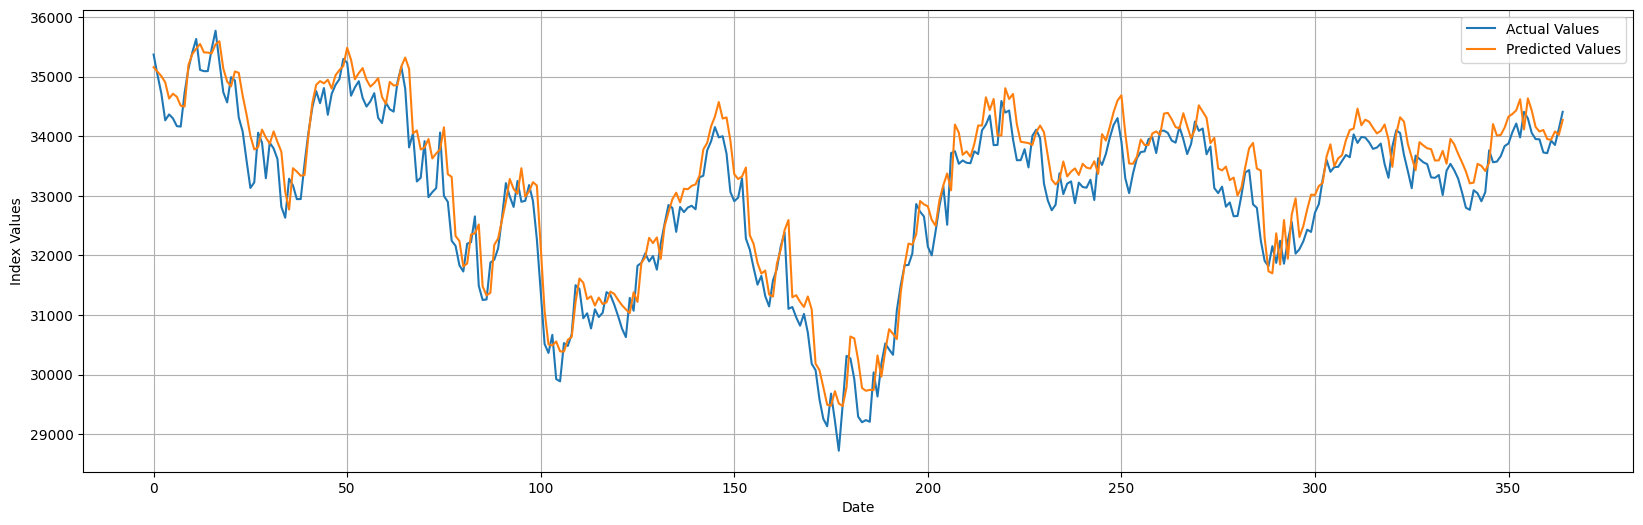

In [112]:
temp = pd.DataFrame(zip(prediction, actual_final), columns=["y_pred", "test"])
# 可视化预测结果和实际数据
plt.figure(figsize=(20, 6))
plt.plot(temp.index, temp["test"], label="Actual Values")
plt.plot(temp.index, temp["y_pred"], label="Predicted Values")
plt.xlabel("Date")
plt.ylabel("Index Values")
plt.legend()
plt.grid()
plt.show()